In [1]:
import gfc
from gfc import *
import numpy as np
import scipy as sp
from scipy.stats import chi2
import copy as cp
from extreme_deconvolution import extreme_deconvolution as xd
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import gridspec as gs
from matplotlib.patches import Ellipse
import matplotlib as mpl
from mcmcplotting import convert_to_stdev_nan
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import Angle
from pygaia.astrometry.vectorastrometry import phaseSpaceToAstrometry, astrometryToPhaseSpace, sphericalToCartesian, normalTriad
from pygaia.astrometry.coordinates import CoordinateTransformation, Transformations
from pygaia.astrometry import constants

galtoicrs = CoordinateTransformation(Transformations.GAL2ICRS)
icrstogal = CoordinateTransformation(Transformations.ICRS2GAL)

rc('font',**{'family':'serif', 'serif':['Times']})
rc('text', usetex=True)

In [2]:
root = '/disks/strw9/vanweenen/mrp1/data/'

#hipfile = 'Gaia_DR1_hipparcos_plx:eplx<0.1_nobinary'
tgasfile = 'Gaia_DR1_tgas_2mass_qualAAA_plx:eplx<0.1_MScut'

print "Reading files.."
#t_hip = gfc.io.read_csv(root + 'original/' + hipfile + '.csv')
t_tgas = gfc.io.read_csv(root + 'MS cut/' + tgasfile + '.csv')[:500]

Reading files..


In [3]:
N = len(t_tgas)
print N

Kmin=1 ; Kmax=20 ; Kstep=1
wmin = 0.5 ; wmax=15 ; wstep=1.

500


In [4]:
# Use parameters from Bovy 2009 as initial velocity distribution.
amps_Bovy = gfc.io.load('/disks/strw9/vanweenen/mrp1/gfc/Bovy_parameters/' + 'Bovy_amps.npy')
means_Bovy = gfc.io.load('/disks/strw9/vanweenen/mrp1/gfc/Bovy_parameters/' + 'Bovy_means.npy')
covs_Bovy = gfc.io.load('/disks/strw9/vanweenen/mrp1/gfc/Bovy_parameters/' + 'Bovy_covs.npy')

amps_Bovy /= np.sum(amps_Bovy)

initamps = []
initmeans = []
initcovs = []

for k in range(len(amps_Bovy)):
    initamps.append(amps_Bovy[:k+1])
    initmeans.append(means_Bovy[:k+1])
    initcovs.append(covs_Bovy[:k+1])

In [5]:
print "Projection.."
# Calculate the projection matrix analogous to equation (1) in Bovy et al 2009 
# (https://ui.adsabs.harvard.edu/#abs/2009ApJ...700.1794B/abstract). Note the different ordering of the
# velocity components.
gfc.add_rad(t_tgas, 'ra', u.degree, errunit=u.mas)
gfc.add_rad(t_tgas, 'dec', u.degree, errunit=u.mas)

matrix.transformation(t_tgas)
warr = gfc.XD_arr(t_tgas, "w")
wcovar = gfc.XD_arr(t_tgas, "S") ; wcovar[:,2,2] = 1e15
proj = gfc.XD_arr(t_tgas, "R")
varr = gfc.XD_arr(t_tgas, "UVW")

print "Done"

Projection..
Transforming to radians for..  ra
Transforming to radians for..  dec
w
pqr
R
C
Q
S
UVW
Done


In [6]:
# Perform XD
print "Perform XD.."
# The input to XD are the values of v_alpha*, v_delta, vrad. The other input required is the projection matrix.
# The values of v_alpha*, v_delta, vrad are obtained from (alpha, delta, parallax, mura,  mudec, vrad).
wrange = np.arange(wmin, wmax + wstep, wstep)**2.
Krange = range(Kmin, Kmax + Kstep, Kstep) #Krange from Kmin to Kmax

logL, AIC, MDL, amps_test, means_test, covs_test, bestK, bestw = gfc.perform_XD(warr, wcovar, proj, initamps, initmeans, initcovs, wrange, Krange, N)

Perform XD..
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [7]:
print "XD:"
print "logLikelihood: best K = {0}, best w = {1}".format(bestK[0], bestw[0])
print "amps: {0}, means: {1}, covs: {2}".format(amps_test[0], means_test[0], covs_test[0])
print "AIC: best K = {0}, best w = {1}".format(bestK[1], bestw[1])
print "amps: {0}, means: {1}, covs: {2}".format(amps_test[1], means_test[1], covs_test[1])
print "MDL: best K = {0}, best w = {1}".format(bestK[2], bestw[2])
print "amps: {0}, means: {1}, covs: {2}".format(amps_test[2], means_test[2], covs_test[2])

XD:
logLikelihood: best K = 20, best w = 20.25
amps: [0.1480385  0.13123286 0.08769742 0.08290581 0.07526765 0.07309165
 0.06377487 0.05829733 0.05234458 0.04910091 0.03670721 0.03466745
 0.03123433 0.02081647 0.01725731 0.0121421  0.00836471 0.00754868
 0.00751016 0.002     ], means: [[-6.84931895e+01 -4.05386788e+01 -3.22469753e+01]
 [ 1.58535610e+01 -4.41667916e+01  3.30035824e+00]
 [ 1.74485260e+01 -1.59814740e+01 -1.23998232e+01]
 [-2.65250304e+01 -9.19919720e+00 -1.43714301e+01]
 [-2.27453835e+00 -2.32850041e+00 -6.94050556e+00]
 [ 2.50631709e+01 -5.76490511e+00  5.87347474e+00]
 [-5.97660512e+00 -2.31263138e+01 -7.04814476e+00]
 [-2.84307188e+01 -1.86370787e+01  1.78971564e+01]
 [-2.53309248e+01 -2.04288695e+01  5.21192812e+00]
 [ 4.80395862e+01 -1.92055459e-01 -1.29234291e+00]
 [ 6.40563110e+01 -3.42572238e+01  4.10794078e+01]
 [ 4.32950571e+01 -1.55695613e+01  8.45820642e+00]
 [-3.55113804e+01  4.01679751e+00 -9.93874721e+00]
 [ 6.77238564e+00 -1.27055862e+00 -5.89468526e+01]


In [8]:
gfc.io.save_PDFs(amps_test, means_test, covs_test, root + '/Gaia')

In [9]:
def plot_normal_PDF(ax, v, x, amps, means, covs, c, l):
    pdf = np.zeros(len(x))
    for n in range(len(amps)):
        pdf += amps[n]*sp.stats.norm.pdf(x, loc=means[n,v], scale=np.sqrt(covs[n,v,v]))
    ax.plot(x, pdf, label=l, color=c, lw=.8)

def plot_hist_uvw(inita, initm, initc, a_test, m_test, c_test, uvw_data, *args):
    saveto = '/disks/strw9/vanweenen/mrp1/results/'
    velocities = ('U', 'V', 'W') ; unit = ' (km/s)'
    colors = ('red','dodgerblue','green')
    test = ('logL', 'AIC', 'MDL')
    limits = ((-130, 120), (-120,60), (-70,70))
    
    fig, ax = plt.subplots(len(test), len(velocities), sharey=True, figsize=(9,9), tight_layout=True)
    for v in range(len(velocities)):
        vrange = np.linspace(limits[v][0], limits[v][1], len(uvw_data[:,v]))
        for t in range(len(test)):
            plot_normal_PDF(ax[t,v], v, vrange, a_test[t], m_test[t], c_test[t], colors[t], test[t]) #xd fit
            plot_normal_PDF(ax[t,v], v, vrange, inita, initm, initc, 'black', 'Bovy') #curve of initial velocity distribution
            ax[t,v].hist(uvw_data[:,v], bins='auto', normed=True, facecolor='black', histtype='stepfilled', alpha=0.3, label='data')
            ax[t,v].set_xlabel(velocities[v] + unit)
            ax[t,v].set_xlim(limits[v])
            ax[t,v].legend(loc='upper right', prop={'size': 6})
    
    suptitle = 'Histogram of velocity in Cartesian coordinates'
    filename = '/hist_velocity'
    suptitle, filename = gfc.gplot.title_filename(suptitle, filename, *args)
    plt.suptitle(suptitle, y=1., fontsize=12)
    plt.savefig(saveto + filename)
    plt.show()

def plot_hist_uvw2(inita, initm, initc, a_test, m_test, c_test, uvw_data, *args):
    saveto = '/disks/strw9/vanweenen/mrp1/results/'
    velocities = ('U', 'V', 'W') ; unit = ' (km/s)'
    colors = ('red','dodgerblue','green')
    test = ('logL', 'AIC', 'MDL')
    limits = ((-130, 120), (-120,60), (-70,70))
    
    fig, ax = plt.subplots(1, len(velocities), sharey=True, figsize=(9,4), tight_layout=True)
    for v in range(len(velocities)):
        vrange = np.linspace(limits[v][0], limits[v][1], len(uvw_data[:,v]))
        for t in range(len(test)):
            plot_normal_PDF(ax[v], v, vrange, a_test[t], m_test[t], c_test[t], colors[t], test[t]) #xd fit
        plot_normal_PDF(ax[v], v, vrange, inita, initm, initc, 'black', 'Bovy') #curve of initial velocity distribution
        ax[v].hist(uvw_data[:,v], bins='auto', normed=True, facecolor='black', histtype='stepfilled', alpha=0.3, label='data')
        ax[v].set_xlabel(velocities[v] + unit)
        ax[v].set_xlim(limits[v])
        ax[v].legend(loc='upper right', prop={'size': 6})
    
    suptitle = 'Histogram of velocity in Cartesian coordinates'
    filename = '/hist_velocity'
    suptitle, filename = gfc.gplot.title_filename(suptitle, filename, *args)
    plt.suptitle(suptitle, y=1., fontsize=12)
    plt.savefig(saveto + filename)
    plt.show()


args: ('Gaia',)
Gaia args detected


/software/local/lib64/python2.7/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


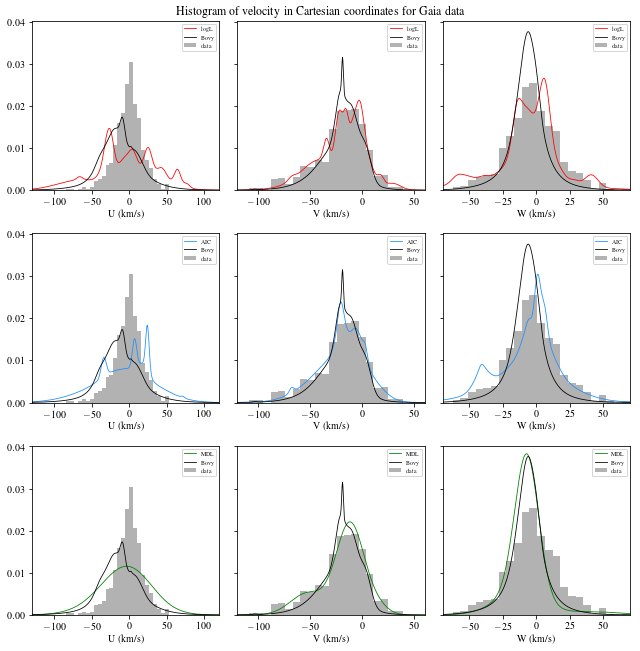

args: ('Gaia',)
Gaia args detected


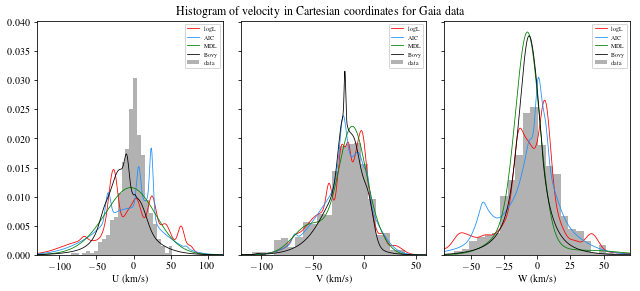

In [10]:
plot_hist_uvw(amps_Bovy[:10], means_Bovy[:10], covs_Bovy[:10], amps_test, means_test, covs_test, varr, 'Gaia')
plot_hist_uvw2(amps_Bovy[:10], means_Bovy[:10], covs_Bovy[:10], amps_test, means_test, covs_test, varr, 'Gaia')

args: ('Gaia',)
Gaia args detected


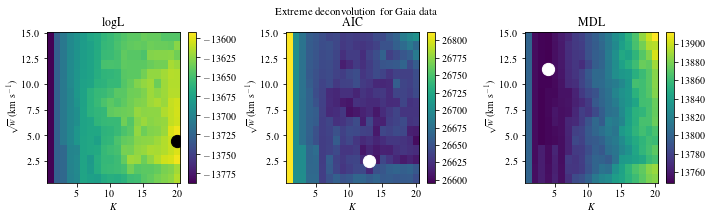

In [11]:
gfc.gplot.plot_XD_w_K(logL, AIC, MDL, bestK, bestw, False, Kmin, Kmax, wmin, wmax, 'Gaia')

In [12]:
def KnownGroups(ax): #before: text
    ax.text(60, -90, "Arcturus")
    ax.plot([8, 57.5], [-105, -90], c='k', lw=2)
    ax.text(-80, -110, "Halo")
    ax.text(50, 40, "Sirius/UMa")
    ax.plot([49, 5], [40, 5], c='k', lw=2)
    ax.text(-100, 45, "Coma Berenices")
    ax.plot([-70, -10], [42, -5], c='k', lw=2)
    ax.text(-120, 34, "NGC 1901")
    ax.plot([-100, -25], [31, -12], c='k', lw=2)
    ax.text(-120, 0, "Hyades")
    ax.plot([-110, -45], [-3, -17], c='k', lw=2)
    ax.text(90, -50, "Pleiades")
    ax.plot([87, -15], [-45, -20], c='k', lw=2)
    ax.text(-125, -42, "Hercules")
    ax.plot([-93.5, -28], [-40, -42], c='k', lw=2)

def totalGaussians(axs, i, j, lsp, amps, means, covs):
    levels=np.array([2,6,12,21,33,50,68,80,90,95,99])/100.0
    xx, yy = np.meshgrid(lsp[j],lsp[i+1])
    pdfxy = np.zeros_like(xx)
    m = np.array([means[:,j], means[:,i+1]]).T
    c = np.array([[covs[:,j,j],covs[:,j,i+1]], [covs[:,i+1,j],covs[:,i+1,i+1]]]).T
    for k in range(len(amps)):
        pdfxy = pdfxy + amps[k] * \
        sp.stats.multivariate_normal.pdf(np.dstack((xx,yy)), mean=m[k], cov=c[k])
    axs[i+j].contour(lsp[j], lsp[i+1], convert_to_stdev_nan(np.log(pdfxy)), levels=levels, colors='k', linewidths=1)
                
def set_axes_3velocities(ax, limits):  
    velocities = ('U', 'V', 'W') ; unit = ' (km/s)'
    xpos = ('top', 'bottom') ; ypos = ('left', 'right')
    for i in range(2):
        for j in range(2):
            if j != i + 1:
                ax[i+j].set_xlim(limits[j]) ; ax[i+j].set_ylim(limits[i+1])
                ax[i+j].set_xlabel(velocities[j] + unit) ; ax[i+j].set_ylabel(velocities[i+1] + unit)
                ax[i+j].xaxis.set_label_position(xpos[i]) ; ax[i+j].yaxis.set_label_position(ypos[j])
    ax[0].xaxis.tick_top()
    ax[0].set_xticks((-100, -50, 0, 50, 100))
    ax[0].set_yticks((-100, -50, 0, 50))
    ax[2].yaxis.tick_right()

def plot_Gaussian_comps(amps, means, covs, t_uvw, total=False, *args):
    saveto = '/disks/strw9/vanweenen/mrp1/results/'
    filename = '/PDF'
    limits = ((-130, 120), (-120,60), (-70,70)); gs = (251, 181, 161)
    if total:
        filename += '_total'
        title = "Velocity distribution"
        #levels = np.logspace(-6.,-2.7,10)
        lsp = [np.linspace(limits[i][0], limits[i][1], gs[i]) for i in range(3)]
    else:
        line = ("xy", "xz", "yz") 
        title = "Gaussian components of velocity distribution"
    title, filename = gfc.gplot.title_filename(title, filename, *args)
    fig = plt.figure(figsize=(8,8))
    plt.suptitle(title)
    ax = [plt.subplot(2,1,1), plt.subplot(2,2,3), plt.subplot(2,2,4)]
    for i in range(2):
        for j in range(2):
            if j != i +1:
                if total:
                    totalGaussians(ax, i, j, lsp, amps, means, covs)
                else:
                    for a, m, c in zip(amps, means, covs):
                        gfc.gplot.draw_PDF_ellipse(ax[i+j], a, m, c, line[i+j], edgecolor="0.4")
                ax[i+j].hexbin(t_uvw[:,j], t_uvw[:,i+1], gridsize=gs[i+j], bins='log', mincnt=1, alpha=.4, lw=0.)
    set_axes_3velocities(ax, limits)    
    KnownGroups(ax[0])
    fig.savefig(saveto + filename)
    plt.show()

args: ('Bovy',)
Bovy args detected


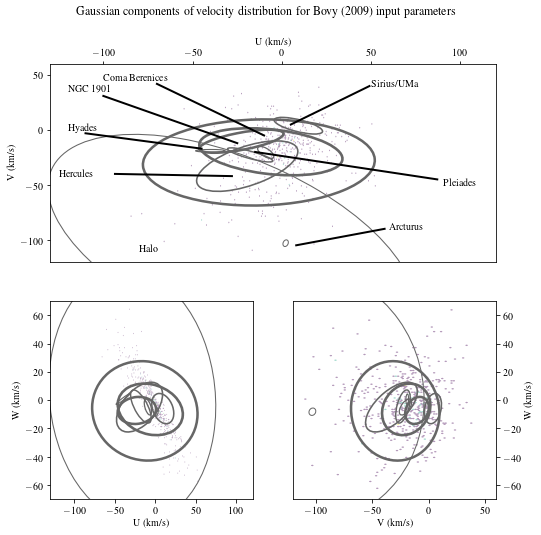

args: ('Bovy', 'XD')
Bovy args detected


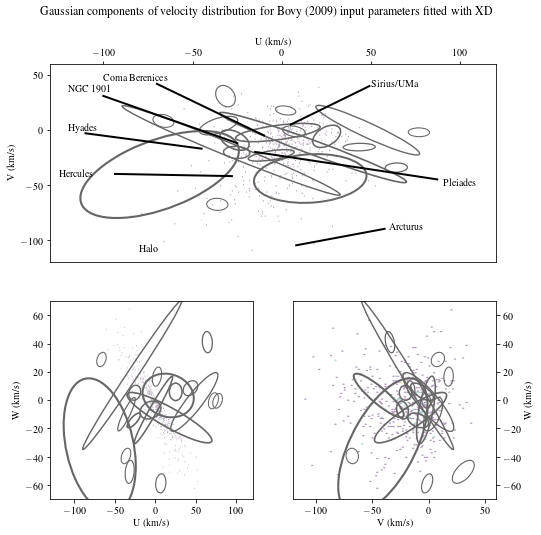

args: ('Bovy', 'AIC')
Bovy args detected


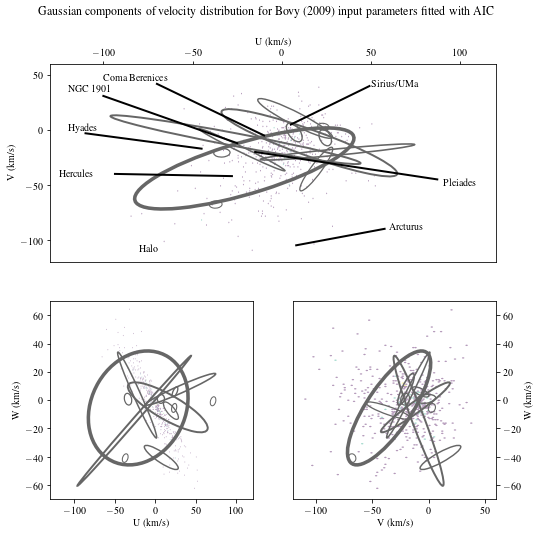

args: ('Bovy', 'MDL')
Bovy args detected


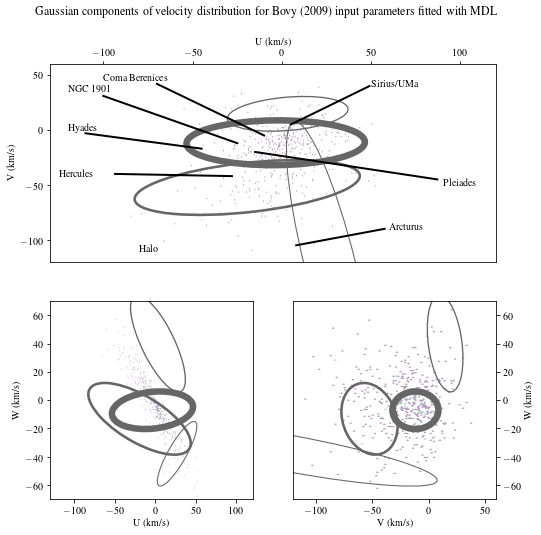

In [13]:
plot_Gaussian_comps(amps_Bovy[:10], means_Bovy[:10], covs_Bovy[:10], varr, False, 'Bovy')
tests = ('XD', 'AIC', 'MDL')
for i in range(3):
    plot_Gaussian_comps(amps_test[i], means_test[i], covs_test[i], varr, False, 'Bovy', tests[i])

args: ('Bovy',)
Bovy args detected


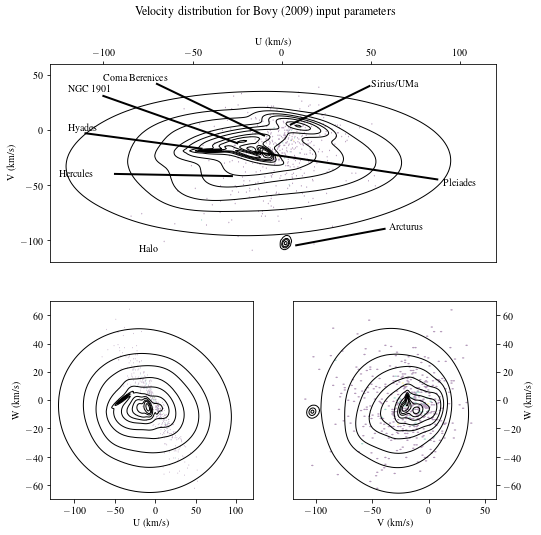

args: ('Bovy', 'XD')
Bovy args detected


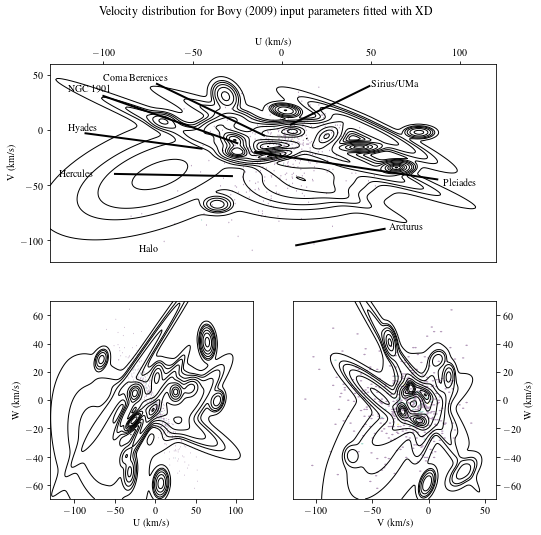

args: ('Bovy', 'AIC')
Bovy args detected


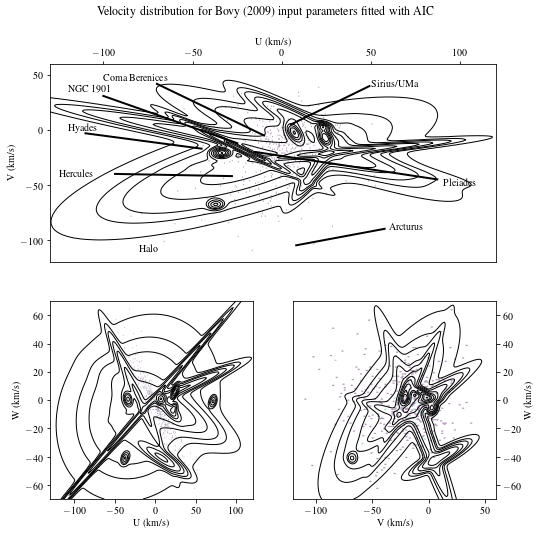

args: ('Bovy', 'MDL')
Bovy args detected


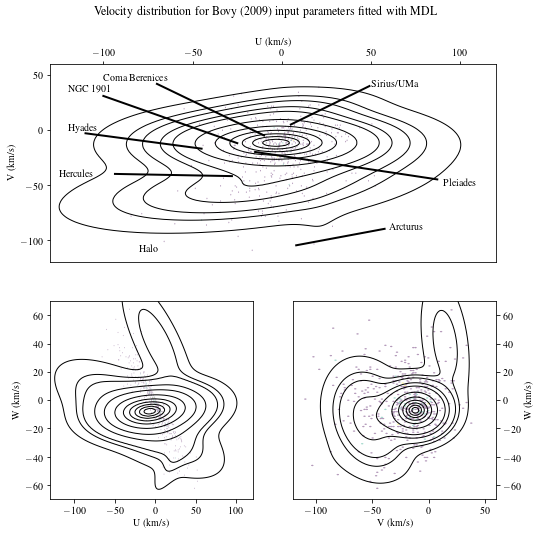

In [14]:
plot_Gaussian_comps(amps_Bovy[:10], means_Bovy[:10], covs_Bovy[:10], varr, True, 'Bovy')
tests = ('XD', 'AIC', 'MDL')
for i in range(3):
    plot_Gaussian_comps(amps_test[i], means_test[i], covs_test[i], varr, True, 'Bovy', tests[i])